In [1]:
import random
import os
import shutil
import copy
from skimage import measure
from skimage import morphology as skim
import skimage.io as skio
import warnings
import pandas as pd
import numpy as np
import pathlib
import yaml
import geopandas as gpd
from rasterio import features, coords
import rasterio
from shapely.geometry import shape
import matplotlib.pyplot as plt
import gdal
random.seed(4)

In [2]:
def parse_yaml(input_file):
    """Parse yaml file of configuration parameters."""
    with open(input_file, 'r') as yaml_file:
        params = yaml.load(yaml_file)
    return params

params = parse_yaml('preprocess_config.yaml') 

ROOT = params['dirs']['root']

DATASET = os.path.join(
    ROOT, params['dirs']['dataset'])

REORDER = os.path.join(
    DATASET, params['dirs']['reorder'])

TRAIN = os.path.join(
    DATASET, params['dirs']['train'])

TEST = os.path.join(
    DATASET, params['dirs']['test'])

GRIDDED_IMGS = os.path.join(
    DATASET, params['dirs']['gridded_imgs'])

GRIDDED_LABELS = os.path.join(
    DATASET, params['dirs']['gridded_labels'])

OPENED = os.path.join(
    DATASET, params['dirs']['opened'])

RESULTS = os.path.join(ROOT,'../',params['dirs']['results'], params['dirs']['dataset'])

SOURCE_IMGS = os.path.join(
    ROOT, params['dirs']['source_imgs'])

SOURCE_LABELS = os.path.join(
    ROOT, params['dirs']['source_labels'])

NEG_BUFFERED = os.path.join(
    DATASET, params['dirs']['neg_buffered_labels'])

dirs = [DATASET, REORDER, TRAIN, TEST, GRIDDED_IMGS, GRIDDED_LABELS, OPENED, NEG_BUFFERED, RESULTS]

# Make directory and subdirectories
for d in dirs:
    pathlib.Path(d).mkdir(parents=True, exist_ok=True)

# Change working directory to project directory
os.chdir(dirs[1])

In [3]:
def negative_buffer_and_small_filter(params):
    """
    Applies a negative buffer to wv2 labels since some are too close together and 
    produce conjoined instances when connected components is run (even after 
    erosion/dilation). This may not get rid of all conjoinments and should be adjusted.
    It relies too on the source projection of the label file to calculate distances for
    the negative buffer. Currently hardcodes in projections, need to look up utm pojection
    based on spatial location somehow if I'm to extend this to work with labels anywhere.

    Returns rasterized labels that are ready to be gridded
    """
    class_int = params['label_vals']['class']
    neg_buffer = float(params['label_vals']['neg_buffer'])
    small_area_filter = float(params['label_vals']['small_area_filter'])
    big_area_filter = float(params['label_vals']['big_area_filter'])
    # This is a helper  used with sorted for a list of strings by specific indices in 
    # each string. Was used for a long path that ended with a file name
    # Not needed here but may be with different source imagery and labels
    # def takefirst_two(elem):
    #     return int(elem[-12:-10])

    items = os.listdir(SOURCE_LABELS)
    labels = []
    for name in items:
        if name.endswith(".shp"):
            labels.append(os.path.join(SOURCE_LABELS,name))  

    shp_list = sorted(labels)
    # need to use Source imagery for geotransform data for rasterized shapes, didn't preserve when save imgs to reorder
    scenes = os.listdir(SOURCE_IMGS)
    scenes = [scene for scene in scenes if 'GS' in scene]
    img_list = []
    for name in scenes:
        img_list.append(os.path.join(SOURCE_IMGS,name))  

    img_list = sorted(img_list)


    for shp_path, img_path in zip(shp_list, img_list):
        shp_frame = gpd.read_file(shp_cakpath)
        print(shp_path)
        display(shp_frame)
        # keeps the class of interest if ity is there and the polygon of raster extent
        shp_frame = shp_frame[(shp_frame['class'] == class_int) | (shp_frame['DN'] == 1)]
        display(shp_frame)
        with rasterio.open(img_path) as rast:
            meta = rast.meta.copy()
            meta.update(compress="lzw")
            meta['count'] = 1
        tifname = os.path.splitext(os.path.basename(shp_path))[0] + '.tif'
        rasterized_name = os.path.join(NEG_BUFFERED, tifname)
        with rasterio.open(rasterized_name, 'w+', **meta) as out:
            out_arr = out.read(1)
            # we get bounds to deterimine which projection to use for neg buffer
            shp_frame.loc[0,'DN'] = 0
            shp_frame.loc[1:,'DN'] = 1
            display(shp_frame)
            maxx_bound = shp_frame.bounds.maxx.max()
            minx_bound = shp_frame.bounds.minx.min()
            if maxx_bound >= 30 and minx_bound>= 30:
                shp_frame = shp_frame.to_crs({'init': 'epsg:32736'})
                shp_frame['geometry'] = shp_frame['geometry'].buffer(neg_buffer)
                shp_frame['Shape_Area'] = shp_frame.area
                shp_frame = shp_frame.to_crs({'init': 'epsg:4326'})

            else:
                shp_frame = shp_frame.to_crs({'init': 'epsg:32735'})
                shp_frame['geometry'] = shp_frame['geometry'].buffer(neg_buffer)
                shp_frame['Shape_Area'] = shp_frame.area
                shp_frame = shp_frame.to_crs({'init': 'epsg:4326'})

            if len(shp_frame) == 1: # added for case, where entire wv2 scenes have no foreground class and need empty masks
                shapes = ((geom,value) for geom, value in zip(shp_frame.geometry, shp_frame.DN))
                burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform, default_value=1)
                burned[burned < 0] = 0
                out.write_band(1, burned)           
                
            else: # added for center pivot case, where entire wv2 scenes have no center pivots and need empty masks
                shp_frame = shp_frame.loc[shp_frame.Shape_Area > small_area_filter]
                shp_frame = shp_frame.loc[shp_frame.Shape_Area < big_area_filter]
                shp_frame = shp_frame[shp_frame.DN==1] # get rid of extent polygon
                plt.figure()
                shp_frame.plot()
                # https://gis.stackexchange.com/questions/151339/rasterize-a-shapefile-with-geopandas-or-fiona-python#151861
                shapes = ((geom,value) for geom, value in zip(shp_frame.geometry, shp_frame.DN))
                burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform, default_value=1)
                burned[burned < 0] = 0
                out.write_band(1, burned) 
    print('Done applying negbuff of {negbuff} and filtering small labels of area less than {area}'.format(negbuff=neg_buffer,area=small_area_filter))       

In [8]:
NEG_BUFFERED

'/home/rave/tana-crunch/waves/cropmask/data/center-pivots-test-3/neg_buffered_labels'

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


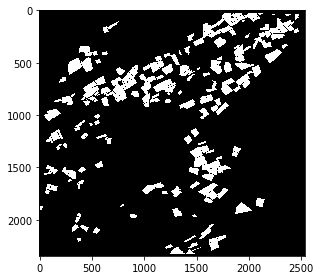

In [7]:
skio.imshow(skio.imread(os.path.join(NEG_BUFFERED,os.listdir(NEG_BUFFERED)[0])))

/home/rave/tana-crunch/waves/cropmask/data/original_steph_labels/1merge.shp


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,1,0,0,0.184109,2.033700e-03,POLYGON ((30.10209854301343 -23.45621482235612...
1,2,0,0,1,0.001545,1.354664e-07,POLYGON ((30.14532930360451 -23.46507696572934...
2,3,0,1,2,0.007259,2.159377e-06,POLYGON ((30.12445615762562 -23.49686998755982...
3,4,0,2,2,0.006597,2.232225e-06,POLYGON ((30.12624986803701 -23.49516823552563...
4,5,0,3,2,0.003779,9.226339e-07,POLYGON ((30.12360759151721 -23.49505021929212...
5,6,0,4,2,0.002892,3.165489e-07,POLYGON ((30.12460923842565 -23.49469742334736...
6,7,0,5,2,0.003745,6.677397e-07,POLYGON ((30.12493879768743 -23.49553049323765...
7,8,0,6,2,0.005123,8.112444e-07,POLYGON ((30.12445870630432 -23.49706884834865...
8,9,0,7,2,0.003916,9.530421e-07,"POLYGON ((30.1243555010056 -23.49686176505838,..."
9,10,0,8,2,0.003875,9.331744e-07,POLYGON ((30.12340597790359 -23.49725193502871...


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,1,0,0,0.184109,2.033700e-03,POLYGON ((30.10209854301343 -23.45621482235612...
2,3,0,1,2,0.007259,2.159377e-06,POLYGON ((30.12445615762562 -23.49686998755982...
3,4,0,2,2,0.006597,2.232225e-06,POLYGON ((30.12624986803701 -23.49516823552563...
4,5,0,3,2,0.003779,9.226339e-07,POLYGON ((30.12360759151721 -23.49505021929212...
5,6,0,4,2,0.002892,3.165489e-07,POLYGON ((30.12460923842565 -23.49469742334736...
6,7,0,5,2,0.003745,6.677397e-07,POLYGON ((30.12493879768743 -23.49553049323765...
7,8,0,6,2,0.005123,8.112444e-07,POLYGON ((30.12445870630432 -23.49706884834865...
8,9,0,7,2,0.003916,9.530421e-07,"POLYGON ((30.1243555010056 -23.49686176505838,..."
9,10,0,8,2,0.003875,9.331744e-07,POLYGON ((30.12340597790359 -23.49725193502871...
10,11,0,9,2,0.003847,9.353637e-07,POLYGON ((30.12208413907183 -23.49665668545765...


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,0,0,0,0.184109,2.033700e-03,POLYGON ((30.10209854301343 -23.45621482235612...
2,3,1,1,2,0.007259,2.159377e-06,POLYGON ((30.12445615762562 -23.49686998755982...
3,4,1,2,2,0.006597,2.232225e-06,POLYGON ((30.12624986803701 -23.49516823552563...
4,5,1,3,2,0.003779,9.226339e-07,POLYGON ((30.12360759151721 -23.49505021929212...
5,6,1,4,2,0.002892,3.165489e-07,POLYGON ((30.12460923842565 -23.49469742334736...
6,7,1,5,2,0.003745,6.677397e-07,POLYGON ((30.12493879768743 -23.49553049323765...
7,8,1,6,2,0.005123,8.112444e-07,POLYGON ((30.12445870630432 -23.49706884834865...
8,9,1,7,2,0.003916,9.530421e-07,"POLYGON ((30.1243555010056 -23.49686176505838,..."
9,10,1,8,2,0.003875,9.331744e-07,POLYGON ((30.12340597790359 -23.49725193502871...
10,11,1,9,2,0.003847,9.353637e-07,POLYGON ((30.12208413907183 -23.49665668545765...


/home/rave/tana-crunch/waves/cropmask/data/original_steph_labels/2merge.shp


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,1,0,0,0.183136,2.061919e-03,POLYGON ((28.00739746871824 -25.00313767196593...
1,2,0,0,1,0.002920,5.202729e-07,POLYGON ((27.98966099166148 -25.03959297983209...
2,3,0,3,2,0.004786,1.242910e-06,POLYGON ((27.99109598948837 -25.00872461125175...
3,4,0,81,1,0.006094,1.932142e-06,POLYGON ((27.98570602960962 -25.03512519826921...
4,5,0,999,1,0.004361,1.081101e-06,POLYGON ((27.98037930196324 -25.04199165159338...
5,6,0,999,1,0.004658,9.923289e-07,POLYGON ((27.97598549863193 -25.04162734972238...
6,7,0,999,1,0.003666,7.843059e-07,POLYGON ((27.98982888789294 -25.03735168493228...
7,8,0,999,1,0.006927,1.937893e-06,POLYGON ((27.98380888637104 -25.04054385281648...
8,9,0,999,1,0.003577,6.703671e-07,"POLYGON ((27.99272789747454 -25.0376182062152,..."
9,10,0,65,1,0.003398,6.681342e-07,POLYGON ((27.99316023665563 -25.03094393261637...


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,1,0,0,0.183136,0.002062,POLYGON ((28.00739746871824 -25.00313767196593...
2,3,0,3,2,0.004786,0.000001,POLYGON ((27.99109598948837 -25.00872461125175...
64,65,0,133,2,0.008119,0.000004,POLYGON ((27.99238479262414 -25.00675424970882...
70,71,0,900,2,0.007660,0.000004,POLYGON ((27.99146873689273 -25.00668570787906...
71,72,0,903,2,0.053804,0.000141,POLYGON ((28.00883948215642 -25.00566316072621...


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,0,0,0,0.183136,0.002062,POLYGON ((28.00739746871824 -25.00313767196593...
2,3,1,3,2,0.004786,0.000001,POLYGON ((27.99109598948837 -25.00872461125175...
64,65,1,133,2,0.008119,0.000004,POLYGON ((27.99238479262414 -25.00675424970882...
70,71,1,900,2,0.007660,0.000004,POLYGON ((27.99146873689273 -25.00668570787906...
71,72,1,903,2,0.053804,0.000141,POLYGON ((28.00883948215642 -25.00566316072621...


/home/rave/tana-crunch/waves/cropmask/data/original_steph_labels/3merge.shp


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,1,0,0,0.183392,2.031024e-03,POLYGON ((30.56601625224829 -23.19231414498176...
1,2,0,0,1,0.009009,3.780391e-06,POLYGON ((30.57265397020461 -23.20146796277623...
2,3,0,0,1,0.009347,4.940973e-06,POLYGON ((30.57033641369458 -23.20310604910486...
3,4,0,0,1,0.003146,5.787839e-07,"POLYGON ((30.57532860523099 -23.201335453968, ..."
4,5,0,0,1,0.003692,6.154681e-07,POLYGON ((30.57640467193812 -23.19983772483107...
5,6,0,0,1,0.003347,5.960864e-07,"POLYGON ((30.57464923487436 -23.1998593049629,..."
6,7,0,0,1,0.002433,3.430739e-07,POLYGON ((30.57417820056355 -23.19987078480881...
7,8,0,0,1,0.006031,1.665866e-06,POLYGON ((30.57331916005126 -23.19878520417382...
8,9,0,0,1,0.003979,9.176640e-07,"POLYGON ((30.5724189413811 -23.19994742233564,..."
9,10,0,0,1,0.003653,4.856067e-07,"POLYGON ((30.57823061045434 -23.19491203816, 3..."


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,1,0,0,0.183392,0.002031,POLYGON ((30.56601625224829 -23.19231414498176...


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,0,0,0,0.183392,0.002031,POLYGON ((30.56601625224829 -23.19231414498176...


/home/rave/tana-crunch/waves/cropmask/data/original_steph_labels/4merge.shp


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,1,0,0,0.184080,2.078306e-03,POLYGON ((25.92169673121924 -25.97855599776102...
1,2,0,2,2,0.018514,1.451284e-05,POLYGON ((25.94846065243723 -26.02209281473159...
2,3,0,2,2,0.040203,9.668601e-05,"POLYGON ((25.9297065304321 -26.02195961614331,..."
3,4,0,3,3,0.018788,2.786712e-05,POLYGON ((25.95291328941681 -25.98829549184342...
4,5,0,3,3,0.018897,2.802900e-05,POLYGON ((25.95827117047821 -25.98629765511265...
5,6,0,3,3,0.014881,1.621364e-05,"POLYGON ((25.96961006295408 -25.981248168668, ..."
6,7,0,3,3,0.021851,3.751619e-05,POLYGON ((25.92538565312543 -25.99102521214377...
7,8,0,2,2,0.035714,6.627685e-05,"POLYGON ((25.92378431849153 -26.0104160820365,..."
8,9,0,2,2,0.018796,1.321049e-05,POLYGON ((25.92683194194063 -25.98137593355244...
9,10,0,2,2,0.003487,6.287678e-07,POLYGON ((25.92300348572235 -25.97857502561692...


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,1,0,0,0.184080,2.078306e-03,POLYGON ((25.92169673121924 -25.97855599776102...
1,2,0,2,2,0.018514,1.451284e-05,POLYGON ((25.94846065243723 -26.02209281473159...
2,3,0,2,2,0.040203,9.668601e-05,"POLYGON ((25.9297065304321 -26.02195961614331,..."
7,8,0,2,2,0.035714,6.627685e-05,"POLYGON ((25.92378431849153 -26.0104160820365,..."
8,9,0,2,2,0.018796,1.321049e-05,POLYGON ((25.92683194194063 -25.98137593355244...
9,10,0,2,2,0.003487,6.287678e-07,POLYGON ((25.92300348572235 -25.97857502561692...
12,13,0,2,2,0.014797,3.984061e-06,"POLYGON ((25.92158256048685 -25.9911378342436,..."
13,14,0,2,2,0.009481,2.604363e-06,POLYGON ((25.92165867460818 -25.98309879087645...
15,16,0,2,2,0.017424,9.383040e-06,POLYGON ((25.93677565407324 -25.99606223938082...
18,19,0,2,2,0.038926,6.710714e-05,POLYGON ((25.94093849891266 -26.02203572936537...


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,0,0,0,0.184080,2.078306e-03,POLYGON ((25.92169673121924 -25.97855599776102...
1,2,1,2,2,0.018514,1.451284e-05,POLYGON ((25.94846065243723 -26.02209281473159...
2,3,1,2,2,0.040203,9.668601e-05,"POLYGON ((25.9297065304321 -26.02195961614331,..."
7,8,1,2,2,0.035714,6.627685e-05,"POLYGON ((25.92378431849153 -26.0104160820365,..."
8,9,1,2,2,0.018796,1.321049e-05,POLYGON ((25.92683194194063 -25.98137593355244...
9,10,1,2,2,0.003487,6.287678e-07,POLYGON ((25.92300348572235 -25.97857502561692...
12,13,1,2,2,0.014797,3.984061e-06,"POLYGON ((25.92158256048685 -25.9911378342436,..."
13,14,1,2,2,0.009481,2.604363e-06,POLYGON ((25.92165867460818 -25.98309879087645...
15,16,1,2,2,0.017424,9.383040e-06,POLYGON ((25.93677565407324 -25.99606223938082...
18,19,1,2,2,0.038926,6.710714e-05,POLYGON ((25.94093849891266 -26.02203572936537...


/home/rave/tana-crunch/waves/cropmask/data/original_steph_labels/5merge.shp


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,1,0,0,0.184466,2.085648e-03,POLYGON ((25.89551844312172 -26.39970488587176...
1,2,0,0,2,0.001771,1.662321e-07,POLYGON ((25.89549937839365 -26.40108388651208...
2,3,0,1,2,0.018397,1.946871e-05,POLYGON ((25.92746419052003 -26.40235314288321...
3,4,0,1,2,0.028591,4.792449e-05,POLYGON ((25.91824422758907 -26.39987646482695...
4,5,0,1,2,0.021416,1.618828e-05,POLYGON ((25.91759869602305 -26.40366813337761...
5,6,0,1,2,0.025698,2.370752e-05,POLYGON ((25.93043948329557 -26.44330496385294...
6,7,0,1,2,0.026346,4.137762e-05,POLYGON ((25.93318016003639 -26.40749001015581...
7,8,0,1,2,0.034904,5.885475e-05,"POLYGON ((25.92937665820625 -26.3999594182925,..."
8,9,0,1,2,0.005432,1.454387e-06,POLYGON ((25.89650684121779 -26.40198899299759...
9,10,0,1,2,0.021826,2.308130e-05,POLYGON ((25.92133846829574 -26.42030544643916...


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,1,0,0,0.184466,2.085648e-03,POLYGON ((25.89551844312172 -26.39970488587176...
1,2,0,0,2,0.001771,1.662321e-07,POLYGON ((25.89549937839365 -26.40108388651208...
2,3,0,1,2,0.018397,1.946871e-05,POLYGON ((25.92746419052003 -26.40235314288321...
3,4,0,1,2,0.028591,4.792449e-05,POLYGON ((25.91824422758907 -26.39987646482695...
4,5,0,1,2,0.021416,1.618828e-05,POLYGON ((25.91759869602305 -26.40366813337761...
5,6,0,1,2,0.025698,2.370752e-05,POLYGON ((25.93043948329557 -26.44330496385294...
6,7,0,1,2,0.026346,4.137762e-05,POLYGON ((25.93318016003639 -26.40749001015581...
7,8,0,1,2,0.034904,5.885475e-05,"POLYGON ((25.92937665820625 -26.3999594182925,..."
8,9,0,1,2,0.005432,1.454387e-06,POLYGON ((25.89650684121779 -26.40198899299759...
9,10,0,1,2,0.021826,2.308130e-05,POLYGON ((25.92133846829574 -26.42030544643916...


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,0,0,0,0.184466,2.085648e-03,POLYGON ((25.89551844312172 -26.39970488587176...
1,2,1,0,2,0.001771,1.662321e-07,POLYGON ((25.89549937839365 -26.40108388651208...
2,3,1,1,2,0.018397,1.946871e-05,POLYGON ((25.92746419052003 -26.40235314288321...
3,4,1,1,2,0.028591,4.792449e-05,POLYGON ((25.91824422758907 -26.39987646482695...
4,5,1,1,2,0.021416,1.618828e-05,POLYGON ((25.91759869602305 -26.40366813337761...
5,6,1,1,2,0.025698,2.370752e-05,POLYGON ((25.93043948329557 -26.44330496385294...
6,7,1,1,2,0.026346,4.137762e-05,POLYGON ((25.93318016003639 -26.40749001015581...
7,8,1,1,2,0.034904,5.885475e-05,"POLYGON ((25.92937665820625 -26.3999594182925,..."
8,9,1,1,2,0.005432,1.454387e-06,POLYGON ((25.89650684121779 -26.40198899299759...
9,10,1,1,2,0.021826,2.308130e-05,POLYGON ((25.92133846829574 -26.42030544643916...


/home/rave/tana-crunch/waves/cropmask/data/original_steph_labels/6merge.shp


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,1,0,0,0.185099,2.058969e-03,POLYGON ((29.57665817933156 -24.99874306643932...
1,2,0,0,1,0.005687,1.027629e-06,POLYGON ((29.54685010514828 -25.02765216031889...
2,3,0,0,1,0.005067,1.369510e-06,POLYGON ((29.55668293716786 -25.02742620295686...
3,4,0,0,1,0.002533,4.067081e-07,"POLYGON ((29.5519785817462 -25.02580483142776,..."
4,5,0,0,1,0.006824,1.151935e-06,POLYGON ((29.55188653163816 -25.02643962778654...
5,6,0,0,1,0.010439,1.580990e-06,POLYGON ((29.54753967471629 -25.02554102339946...
6,7,0,0,1,0.005180,8.722242e-07,POLYGON ((29.54729065783766 -25.02673157650099...
7,8,0,0,1,0.003581,7.584558e-07,POLYGON ((29.54927599668997 -25.02588061279999...
8,9,0,0,1,0.003051,5.597675e-07,POLYGON ((29.54883319569547 -25.02663095675319...
9,10,0,0,1,0.006804,1.349775e-06,POLYGON ((29.54435332454636 -25.02727365815275...


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,1,0,0,0.185099,0.002059,POLYGON ((29.57665817933156 -24.99874306643932...


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,0,0,0,0.185099,0.002059,POLYGON ((29.57665817933156 -24.99874306643932...


/home/rave/tana-crunch/waves/cropmask/data/original_steph_labels/7merge.shp


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,1,0,0,0.184353,2.065235e-03,POLYGON ((31.22038554595622 -25.26977163185529...
1,2,0,0,1,0.004198,1.098008e-06,POLYGON ((31.22392580003572 -25.30683059975235...
2,3,0,0,1,0.004002,9.140708e-07,POLYGON ((31.22407910027033 -25.30753090003094...
3,4,0,0,1,0.002024,2.106133e-07,"POLYGON ((31.23120089990164 -25.3039788000815,..."
4,5,0,0,1,0.005936,1.304185e-06,POLYGON ((31.23090329984745 -25.30473880005553...
5,6,0,0,1,0.004282,6.705887e-07,POLYGON ((31.22505210017431 -25.30230659976974...
6,7,0,0,1,0.004635,8.742157e-07,POLYGON ((31.22499010001314 -25.30122119989841...
7,8,0,0,1,0.004771,1.094802e-06,POLYGON ((31.22319300005694 -25.30204350040719...
8,9,0,0,1,0.002900,3.515045e-07,POLYGON ((31.24857100035143 -25.28143050041723...
9,10,0,0,1,0.002527,3.227684e-07,POLYGON ((31.24785329998986 -25.28141060021898...


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,1,0,0,0.184353,0.002065,POLYGON ((31.22038554595622 -25.26977163185529...


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,0,0,0,0.184353,0.002065,POLYGON ((31.22038554595622 -25.26977163185529...


/home/rave/tana-crunch/waves/cropmask/data/original_steph_labels/8merge.shp


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,1,0,0,0.182692,2.078805e-03,POLYGON ((27.06101029728745 -25.96754363113365...
1,2,0,0,2,0.005506,1.887336e-06,POLYGON ((27.04948252200086 -25.98336187584982...
2,3,0,1,2,0.023025,1.970299e-05,POLYGON ((27.05453263617227 -25.97606749272057...
3,4,0,1,2,0.012571,6.209746e-06,POLYGON ((27.06730950772766 -25.97879855930603...
4,5,0,1,2,0.014176,1.236109e-05,POLYGON ((27.06068710792374 -25.97594341235856...
5,6,0,1,2,0.013865,7.488151e-06,POLYGON ((27.06606638025931 -25.98015215859522...
6,7,0,1,2,0.016785,9.339759e-06,POLYGON ((27.04331018701555 -25.99125070005971...
7,8,0,1,2,0.016399,1.042039e-05,POLYGON ((27.04101238681227 -25.98968616568396...
8,9,0,1,2,0.025727,3.010168e-05,POLYGON ((27.06026387617698 -25.98763314925037...
9,10,0,1,2,0.034888,3.799379e-05,"POLYGON ((27.0531450757847 -25.97997191737005,..."


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,1,0,0,0.182692,2.078805e-03,POLYGON ((27.06101029728745 -25.96754363113365...
1,2,0,0,2,0.005506,1.887336e-06,POLYGON ((27.04948252200086 -25.98336187584982...
2,3,0,1,2,0.023025,1.970299e-05,POLYGON ((27.05453263617227 -25.97606749272057...
3,4,0,1,2,0.012571,6.209746e-06,POLYGON ((27.06730950772766 -25.97879855930603...
4,5,0,1,2,0.014176,1.236109e-05,POLYGON ((27.06068710792374 -25.97594341235856...
5,6,0,1,2,0.013865,7.488151e-06,POLYGON ((27.06606638025931 -25.98015215859522...
6,7,0,1,2,0.016785,9.339759e-06,POLYGON ((27.04331018701555 -25.99125070005971...
7,8,0,1,2,0.016399,1.042039e-05,POLYGON ((27.04101238681227 -25.98968616568396...
8,9,0,1,2,0.025727,3.010168e-05,POLYGON ((27.06026387617698 -25.98763314925037...
9,10,0,1,2,0.034888,3.799379e-05,"POLYGON ((27.0531450757847 -25.97997191737005,..."


,OBJECTID,DN,id,class,Shape_Leng,Shape_Area,geometry
0,1,0,0,0,0.182692,2.078805e-03,POLYGON ((27.06101029728745 -25.96754363113365...
1,2,1,0,2,0.005506,1.887336e-06,POLYGON ((27.04948252200086 -25.98336187584982...
2,3,1,1,2,0.023025,1.970299e-05,POLYGON ((27.05453263617227 -25.97606749272057...
3,4,1,1,2,0.012571,6.209746e-06,POLYGON ((27.06730950772766 -25.97879855930603...
4,5,1,1,2,0.014176,1.236109e-05,POLYGON ((27.06068710792374 -25.97594341235856...
5,6,1,1,2,0.013865,7.488151e-06,POLYGON ((27.06606638025931 -25.98015215859522...
6,7,1,1,2,0.016785,9.339759e-06,POLYGON ((27.04331018701555 -25.99125070005971...
7,8,1,1,2,0.016399,1.042039e-05,POLYGON ((27.04101238681227 -25.98968616568396...
8,9,1,1,2,0.025727,3.010168e-05,POLYGON ((27.06026387617698 -25.98763314925037...
9,10,1,1,2,0.034888,3.799379e-05,"POLYGON ((27.0531450757847 -25.97997191737005,..."


Done applying negbuff of -0.5 and filtering small labels of area less than 100.0


<Figure size 432x288 with 0 Axes>

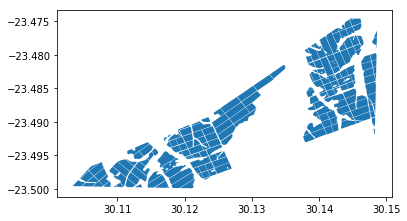

<Figure size 432x288 with 0 Axes>

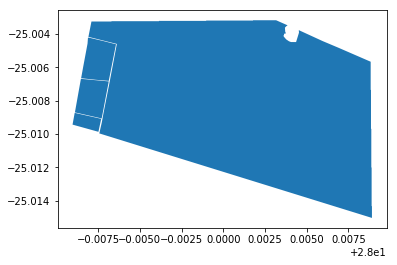

<Figure size 432x288 with 0 Axes>

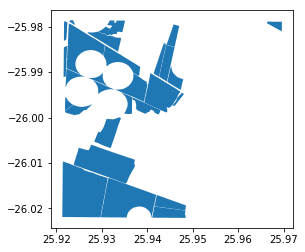

<Figure size 432x288 with 0 Axes>

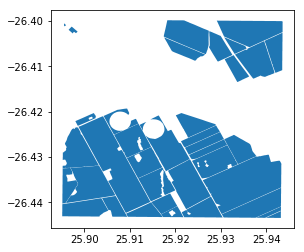

<Figure size 432x288 with 0 Axes>

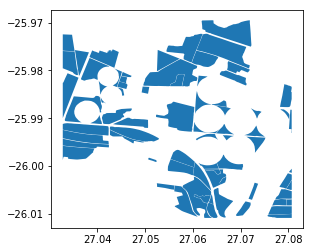

In [4]:
negative_buffer_and_small_filter(params)

In [3]:
def yaml_to_band_index(params):
    band_list = []
    for i, band in enumerate(params['bands_to_include']):
        if list(band.values())[0]== True:
            band_list.append(i)
    return band_list
    
band_indices = yaml_to_band_index(params)

In [4]:
from difflib import SequenceMatcher

def reorder_images(params):
    """Load the os, gs, or both images and subset bands. Growing
    Season is stacked first before OS if both true.
    """
    file_ids_all = next(os.walk(SOURCE_IMGS))[2]
    band_indices = yaml_to_band_index(params)
    image_ids_gs = sorted([image_id for image_id in file_ids_all \
                           if 'GS' in image_id and '.aux' not in image_id])
    image_ids_os = sorted([image_id for image_id in file_ids_all \
                           if 'OS' in image_id and '.aux' not in image_id])
    
    if params['seasons']['GS'] and params['seasons']['OS'] == False:
        for img_path in image_ids_gs:
            gs_image = skio.imread(os.path.join(SOURCE_IMGS, img_path))
            gs_image = gs_image[:,:,band_indices]
            skio.imsave(img_path, gs_image, plugin='tifffile')
            
    elif params['seasons']['OS'] and params['seasons']['GS'] == False:
        for img_path in image_ids_os:
            os_image = skio.imread(os.path.join(SOURCE_IMGS, img_path))
            os_image = gs_image[:,:,band_indices]
            skio.imsave(img_path, os_image, plugin='tifffile')
    else:
        for gs_path, os_path in zip(image_ids_gs, image_ids_os):
            gs_image = skio.imread(os.path.join(SOURCE_IMGS, gs_path))
            os_image = skio.imread(os.path.join(SOURCE_IMGS, os_path))
            gsos_image = np.dstack([gs_image[:,:,band_indices], os_image[:,:,band_indices]])

            match = SequenceMatcher(None, gs_path, os_path).find_longest_match(0, len(gs_path), 0, len(os_path))
            path = gs_path[match.b: match.b + match.size] 
            # this may need to be reworked for diff file names
            # works best if unique ids like GS go in front of filename
            gsos_image_path = os.path.join(REORDER, path + 'OSGS.tif')
            skio.imsave(gsos_image_path, gsos_image, plugin='tifffile')
            
reorder_images(params)

Further test from here and then continue with adjustable gridding

In [5]:
def negative_buffer_and_small_filter(params):
    """
    Applies a negative buffer to wv2 labels since some are too close together and 
    produce conjoined instances when connected components is run (even after 
    erosion/dilation). This may not get rid of all conjoinments and should be adjusted.
    It relies too on the source projection of the label file to calculate distances for
    the negative buffer. Currently hardcodes in projections, need to look up utm pojection
    based on spatial location somehow if I'm to extend this to work with labels anywhere.
    
    Returns rasterized labels that are ready to be gridded
    """
    neg_buffer = float(params['label_vals']['neg_buffer'])
    small_area_filter = float(params['label_vals']['small_area_filter'])
    # This is a helper  used with sorted for a list of strings by specific indices in 
    # each string. Was used for a long path that ended with a file name
    # Not needed here but may be with different source imagery and labels
    # def takefirst_two(elem):
    #     return int(elem[-12:-10])

    items = os.listdir(SOURCE_LABELS)
    labels = []
    for name in items:
        if name.endswith(".shp"):
            labels.append(os.path.join(SOURCE_LABELS,name))  

    shp_list = sorted(labels)
    # need to use Source imagery for geotransform data for rasterized shapes, didn't preserve when save imgs to reorder
    scenes = os.listdir(SOURCE_IMGS)
    scenes = [scene for scene in scenes if 'GS' in scene]
    img_list = []
    for name in scenes:
        img_list.append(os.path.join(SOURCE_IMGS,name))  

    img_list = sorted(img_list)


    for shp_path, img_path in zip(shp_list, img_list):
        shp_frame = gpd.read_file(shp_path)
        with rasterio.open(img_path) as rast:
            meta = rast.meta.copy()
            meta.update(compress="lzw")
            meta['count'] = 1
        tifname = os.path.splitext(os.path.basename(shp_path))[0] + '.tif'
        rasterized_name = os.path.join(NEG_BUFFERED, tifname)
        with rasterio.open(rasterized_name, 'w+', **meta) as out:
            out_arr = out.read(1)
            # we get bounds to deterimine which projection to use for neg buffer
            shp_frame.loc[0,'DN'] = 0
            shp_frame.loc[1:,'DN'] = 1
            maxx_bound = shp_frame.bounds.maxx.max()
            minx_bound = shp_frame.bounds.minx.min()
            if maxx_bound >= 30 and minx_bound>= 30:
                shp_frame = shp_frame.to_crs({'init': 'epsg:32736'})
                shp_frame['geometry'] = shp_frame['geometry'].buffer(neg_buffer)
                shp_frame['Shape_Area'] = shp_frame.area
                shp_frame = shp_frame.to_crs({'init': 'epsg:4326'})

            else:
                shp_frame = shp_frame.to_crs({'init': 'epsg:32735'})
                shp_frame['geometry'] = shp_frame['geometry'].buffer(neg_buffer)
                shp_frame['Shape_Area'] = shp_frame.area
                shp_frame = shp_frame.to_crs({'init': 'epsg:4326'})

            # filtering out very small fields, in meters. 100 meters area looks like a good number for now
            shp_frame = shp_frame.loc[shp_frame.Shape_Area > small_area_filter]
            shp_frame = shp_frame[shp_frame.DN==1] # get rid of extent polygon
            # https://gis.stackexchange.com/questions/151339/rasterize-a-shapefile-with-geopandas-or-fiona-python#151861
            shapes = ((geom,value) for geom, value in zip(shp_frame.geometry, shp_frame.DN))
            burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform, default_value=1)
            burned[burned < 0] = 0
            out.write_band(1, burned) 
    print('Done applying negbuff of {negbuff} and filtering small labels of area less than {area}'.format(negbuff=neg_buffer,area=small_area_filter))
negative_buffer_and_small_filter(params)

Done applying negbuff of -0.5 and filtering small labels of area less than 100.0


In [6]:
def rm_mostly_empty(scene_path, label_path):
    '''
    Removes a grid that is mostly (over 1/4th) empty and corrects bad no data value to 0.
    Ignor ethe User Warning, unsure why it pops up but doesn't seem to impact the array shape
    '''
    usable_data_threshold = params['image_vals']['usable_thresh']
    arr = skio.imread(scene_path)
    arr[arr<0] = 0
    skio.imsave(scene_path, arr)
    pixel_count = arr.shape[0] * arr.shape[1]
    nodata_pixel_count = (arr == 0).sum()
    if 1-(nodata_pixel_count/pixel_count) < usable_data_threshold:
        os.remove(scene_path)
        os.remove(label_path)
        print('removed scene and label, less than {}% good data'.format(usable_data_threshold))
            
def grid_images(params):
    """
    Grids up imagery to a variable size. Filters out imagery with too little usable data.
    appends a random unique id to each tif and label pair, appending string 'label' to the 
    mask.
    """
    img_list = sorted(next(os.walk(REORDER))[2])
    label_list = sorted(next(os.walk(NEG_BUFFERED))[2])

    for img_name, label_name in zip(img_list, label_list):
        img_path = os.path.join(REORDER, img_name)
        label_path = os.path.join(NEG_BUFFERED, label_name)
        #assign unique name to each gridded tif, keeping season suffix
        #assigning int of same length as ZA0932324 naming convention

        tile_size_x = params['image_vals']['grid_size']
        tile_size_y = params['image_vals']['grid_size']
        ds = gdal.Open(img_path)
        band = ds.GetRasterBand(1)
        xsize = band.XSize
        ysize = band.YSize   

        for i in range(0, xsize, tile_size_x):
            for j in range(0, ysize, tile_size_y):
                unique_id = str(random.randint(100000000,999999999))
                out_path_img = os.path.join(GRIDDED_IMGS,unique_id)+ '.tif'
                out_path_label = os.path.join(GRIDDED_LABELS,unique_id)+ '_label.tif'
                com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " + str(img_path) + " " + str(out_path_img)
                os.system(com_string)
                com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " + str(label_path) + " " + str(out_path_label)
                os.system(com_string)
                rm_mostly_empty(out_path_img, out_path_label)
grid_images(params)

/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (512, 512, 3) to (2351, 2548, 3)
  warnings.warn(str(e))


removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data


/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (512, 512, 3) to (2301, 2525, 3)
  warnings.warn(str(e))


removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data


/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (512, 512, 3) to (2345, 2537, 3)
  warnings.warn(str(e))


removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data


/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (512, 512, 3) to (2296, 2541, 3)
  warnings.warn(str(e))


removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data


/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (512, 512, 3) to (2292, 2546, 3)
  warnings.warn(str(e))


removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data


/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (512, 512, 3) to (2325, 2551, 3)
  warnings.warn(str(e))


removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data


/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (512, 512, 3) to (2316, 2547, 3)
  warnings.warn(str(e))


removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data


/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (512, 512, 3) to (2277, 2519, 3)
  warnings.warn(str(e))


removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data
removed scene and label, less than 0.25% good data


In [7]:
def open_labels(params):
    """
    Opens labels with kernel as defined in config.
    """
    k = params['label_vals']['kernel']
    label_list = next(os.walk(GRIDDED_LABELS))[2]
    if params['label_vals']['open'] == True:
        for name in label_list:
            arr = skio.imread(os.path.join(GRIDDED_LABELS,name))
            arr[arr < 0]=0
            opened_path = os.path.join(OPENED,name)
            kernel = np.ones((k,k))
            arr = skim.binary_opening(arr, kernel)
            arr=1*arr
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                skio.imsave(opened_path, 1*arr)
        
        print('Done opening with kernel of h and w {size}'.format(size=k))
        
    else:
        for name in label_list:
            arr = skio.imread(os.path.join(GRIDDED_LABELS,name))
            arr[arr < 0]=0
            opened_path = os.path.join(OPENED,name)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                skio.imsave(opened_path, 1*arr)
open_labels(params)

## Everything up to Opening is done (though didn't plot opening looks like all files are there with right sizes'). Next need to edit move img to train folder and connected components and move masks to test. 

In [8]:
def move_img_to_folder(params):
    '''Moves a file with identifier pattern 760165086_OSGS.tif to a 
    folder path ZA0165086/image/ZA0165086.tif
    Also creates a mask folder at ZA0165086/masks'''
    image_list = os.listdir(GRIDDED_IMGS)
    for img in image_list:
    
        folder_name = os.path.join(TRAIN,img[:9])
        os.mkdir(folder_name)
        new_path = os.path.join(folder_name, 'image')
        mask_path = os.path.join(folder_name, 'mask')
        os.mkdir(new_path)
        file_path = os.path.join(GRIDDED_IMGS,img)
        os.rename(file_path, os.path.join(new_path, img[:9]+'.tif'))
        os.mkdir(mask_path)

move_img_to_folder(params)

In [9]:
def connected_comp(params):
    """
    Extracts individual instances into their own tif files. Saves them
    in each folder ID in train folder
    """
    label_list = next(os.walk(OPENED))[2]
    # save connected components and give each a number at end of id
    for name in label_list:
        arr = skio.imread(os.path.join(OPENED,name))
        blob_labels = measure.label(arr, background=0)
        blob_vals = np.unique(blob_labels)
        #for imgs with no isntances, create empty mask
        if len(blob_vals)==1:
            img_folder = os.path.join(TRAIN,name[:9], 'image')
            img_name = os.listdir(img_folder)[0]
            img_path = os.path.join(img_folder, img_name)
            arr = skio.imread(img_path)
            mask = np.zeros_like(arr[:,:,0])
            mask_folder = os.path.join(TRAIN,name[:9], 'mask')
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                label_stump = os.path.splitext(os.path.basename(name))[0]
                skio.imsave(os.path.join(mask_folder,  label_stump + '_0.tif'),mask)
        # only run connected comp if there is at least one instance
        for blob_val in blob_vals[blob_vals!=0]:
            labels_copy = blob_labels.copy()
            labels_copy[blob_labels!=blob_val] = 0
            labels_copy[blob_labels==blob_val] = 1
            
            label_stump = os.path.splitext(os.path.basename(name))[0]
            label_name = label_stump+'_'+str(blob_val)+'.tif'
            mask_path = os.path.join(TRAIN,name[:9], 'mask')
            label_path = os.path.join(mask_path,label_name)
            assert labels_copy.ndim == 2
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                skio.imsave(label_path, labels_copy)

connected_comp(params)

In [12]:
def train_test_split(params):
    """Takes a sample of folder ids and copies them to a test directory
    from a directory with all folder ids. Each sample folder contains an 
    images and corresponding masks folder."""
    
    k = params['image_vals']['split']
    sample_list = next(os.walk(TRAIN))[1]
    k = round(k*len(sample_list))
    test_list = random.sample(sample_list,k)
    for test_sample in test_list:
        shutil.copytree(os.path.join(TRAIN,test_sample),os.path.join(TEST,test_sample))
    train_list = list(set(next(os.walk(TRAIN))[1]) - set(TEST))
    train_df = pd.DataFrame({'train': train_list})
    test_df = pd.DataFrame({'test': test_list})
    train_df.to_csv(os.path.join(RESULTS, 'train_ids.csv'))
    test_df.to_csv(os.path.join(RESULTS, 'test_ids.csv'))
    
train_test_split(params)

In [14]:
id_list = next(os.walk(TRAIN))[1]
id_list

['281108323',
 '166796611',
 '447392221',
 '127569485',
 '188702168',
 '273216680',
 '608511121',
 '772538987',
 '966136364',
 '401112864',
 '990046123',
 '751243197',
 '732185559',
 '264185459',
 '779318849',
 '359697527',
 '163715329',
 '317615917',
 '921586702',
 '127530394',
 '852562794',
 '309514056',
 '760815157',
 '562828914',
 '119528705',
 '196744404',
 '674045776',
 '713595951',
 '605990184',
 '492120663',
 '592867639',
 '313365594',
 '468125156',
 '826737583',
 '978243289',
 '902023599',
 '353454709',
 '406753139',
 '743077375',
 '937245412',
 '285397122',
 '221996651',
 '208425843',
 '425664383',
 '422386409',
 '959474321',
 '588322035',
 '412377537',
 '932407002',
 '921635620',
 '138197246',
 '276972257',
 '148100622',
 '445136007',
 '509777070',
 '643263730',
 '455738425',
 '543234884',
 '309995440',
 '410714842',
 '446614880',
 '830191378',
 '391786935',
 '963663244',
 '742966981',
 '941540510',
 '193113010',
 '686510044',
 '171337767',
 '315029068',
 '345746688',
 '5768